In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
excluded_sessions = [
    750203572, #horribly noisy!
] #ophys IDs of sessions that should be excluded

## useful functions

In [3]:
def fix_path(path):
    if sys.platform == 'linux':
        return path.replace('\\','/')
    else:
        return path
    
def isint(string):
    try:
        int(string)
        return True
    except ValueError:
        return False
    
def get_colors_for_image_sets():
    colors = [sns.color_palette()[3]] + sns.color_palette('Blues_r', 5)[:3]
    # colors = sns.color_palette()
    # colors = [colors[3],colors[0],colors[2],colors[4]]
    return colors

def designate_flashes(ax,omit=None,pre_color='blue',post_color='blue'):
    '''add vertical spans to designate stimulus flashes'''
    lims = ax.get_xlim()
    for flash_start in np.arange(0,lims[1],0.75):
        if flash_start != omit:
            ax.axvspan(flash_start,flash_start+0.25,color=post_color,alpha=0.25,zorder=-np.inf)
    for flash_start in np.arange(-0.75,lims[0]-0.001,-0.75):
        if flash_start != omit:
            ax.axvspan(flash_start,flash_start+0.25,color=pre_color,alpha=0.25,zorder=-np.inf)
       

## open manifest, add some columns

In [4]:
manifest_path = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_analysis\visual_behavior_pilot_manuscript_resubmission\visual_behavior_data_manifest_with_eyetracking.csv'
manifest_path = manifest_path.replace('\\','/')

manifest = pd.read_csv(manifest_path)

## open summary of sync issues

In [5]:
sync_issue_summary = pd.read_csv('//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_ophys_pilot_sync_line_summary.csv')
sync_issue_summary.head()

,behavior_monitoring_sync_count,behavior_movie_frames,experiment_id,eye_movie_frames,eye_tracking_sync_count,ophys_session_id,eye_matches_behavior,eye_matches_eye,eye_beh_diff
0,110394,110316,644942849,110362,110371,644919226,False,False,32
1,119306,119271,645035903,119293,119303,644953594,False,False,13
2,115876,116136,645086795,115868,116164,645055845,False,False,8
3,109152,109006,645362806,109150,109020,645326094,False,False,2
4,112515,112501,646922970,112511,112521,646846415,False,False,4


In [6]:
manifest = manifest.merge(sync_issue_summary, left_on='ophys_session_id', right_on='ophys_session_id')

## define 'good sync' sessions as those with no frame count mismatches. This could be relaxed

In [7]:
maximum_eyetracking_frame_mismatch = 0

def has_good_sync(osid, maximum_eyetracking_frame_mismatch):
    return sync_issue_summary.query('ophys_session_id == @osid')['eye_beh_diff'].iloc[0] <= maximum_eyetracking_frame_mismatch
manifest['has_good_sync'] = manifest['ophys_session_id'].map(lambda osid:has_good_sync(osid, maximum_eyetracking_frame_mismatch))
manifest['has_eyetracking'] = pd.notnull(manifest['eye_tracking_ellipse_path'])

In [8]:
print('{:0.2f}% of sessions meet the "good_sync" threshold'.format(100*manifest['has_good_sync'].mean()))

72.28% of sessions meet the "good_sync" threshold


In [9]:
len(manifest)

101

In [12]:
manifest['has_good_sync'].sum()

73

In [13]:
101-73

28

## define 'good' sessions as those with eyetracking and meeting the 'good_sync' threshold

In [14]:
good_sessions = manifest.query('has_good_sync == True and has_eyetracking == True and ophys_session_id not in @excluded_sessions')

In [16]:
len(manifest) - len(good_sessions)

38

## load the pre-computed omitted response averages
These are calculated as follows:
    * for every omission, the pupil diameter is extracted for 10 seconds before/after the event
    * the diameter is converted to a fractional change by subtracting off the mean over the entire 20 second window, then dividing by the mean over the entire 20 second window

In [30]:
savedir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_pilot_eyetracking/omission_triggered_averages'
omitted_response_averages = pd.read_csv(os.path.join(savedir,'omission_responses_session_averages_pixels.csv'))

## make one plot per session type, with individual sessions in gray

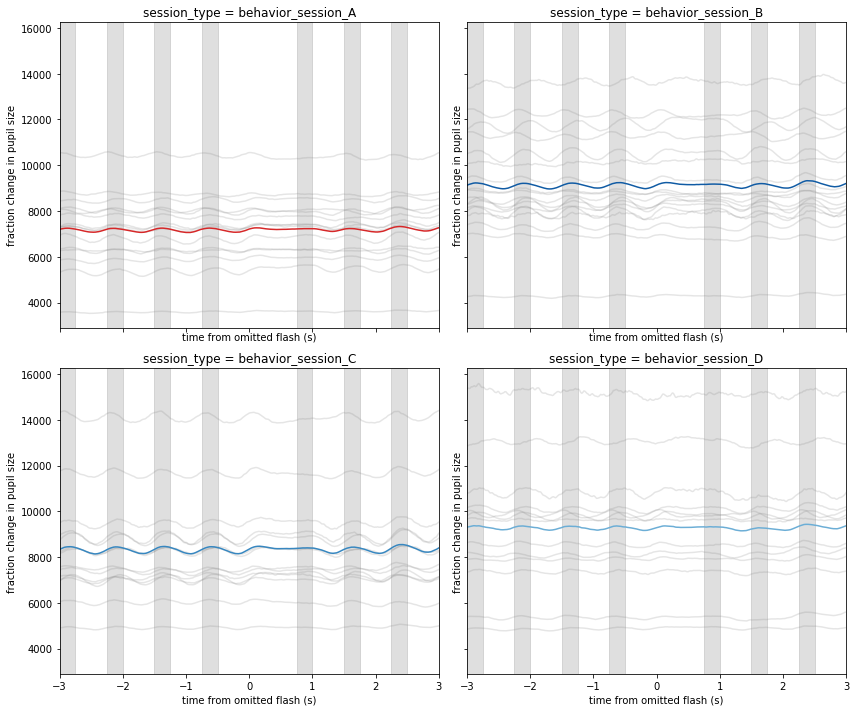

In [31]:
session_types = np.sort(good_sessions.session_type.unique())
colors = get_colors_for_image_sets()

fig,axes=plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)

for ii,session_type in enumerate(session_types):
    ax = axes.flatten()[ii]
    
    # get good sessions of this session type
    sessions = good_sessions.query('session_type == @session_type')
    
    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]
    
    #plot individual session averages as gray lines
    for col in cols:
        ax.plot(omitted_response_averages['time'],omitted_response_averages[col],color='gray',alpha=0.2)
    
    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])
    
    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
#     ax.set_ylim(-0.05,0.05)
    ax.set_title('session_type = {}'.format(session_type))
    
fig.tight_layout()

In [20]:
omitted_response_averages[cols].mean(axis=1)

0       0.709979
1       0.709871
2       0.709475
3       0.709338
4       0.709514
5       0.709714
6       0.710152
7       0.710973
8       0.711902
9       0.712652
10      0.713594
11      0.714891
12      0.716173
13      0.717438
14      0.718288
15      0.719055
16      0.720146
17      0.721488
18      0.722498
19      0.722823
20      0.722811
21      0.723110
22      0.723151
23      0.722848
24      0.722655
25      0.722527
26      0.722216
27      0.721667
28      0.721114
29      0.720372
30      0.719487
31      0.719096
32      0.718897
33      0.718191
34      0.717311
35      0.716449
36      0.715568
37      0.714881
38      0.714382
39      0.713978
40      0.713686
41      0.713275
42      0.712443
43      0.711736
44      0.711153
45      0.710391
46      0.709619
47      0.709258
48      0.709438
49      0.709629
50      0.709602
51      0.709864
52      0.710548
53      0.711232
54      0.712087
55      0.713110
56      0.714337
57      0.715789
58      0.7171

## make one combined plot

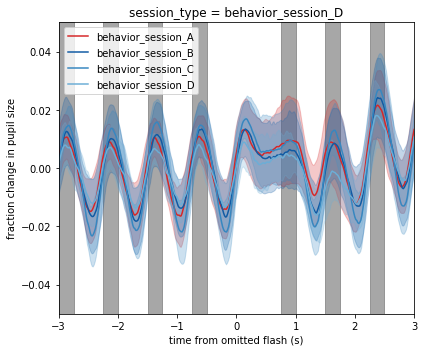

In [12]:
fig,ax=plt.subplots(figsize=(6,5))

for ii,session_type in enumerate(session_types):
    
    # get good sessions of this session type
    sessions = good_sessions.query('session_type == @session_type')
    
    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]
    
    # plot standard deviation as span
    ax.fill_between(
        omitted_response_averages['time'],
        omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
        omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
        color = colors[ii],
        alpha=0.25
    )
    
    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])
    
    
    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
    ax.set_ylim(-0.05,0.05)
    ax.set_title('session_type = {}'.format(session_type))
    
ax.legend(session_types,loc='upper left')
fig.tight_layout()

## make one plot per cre line

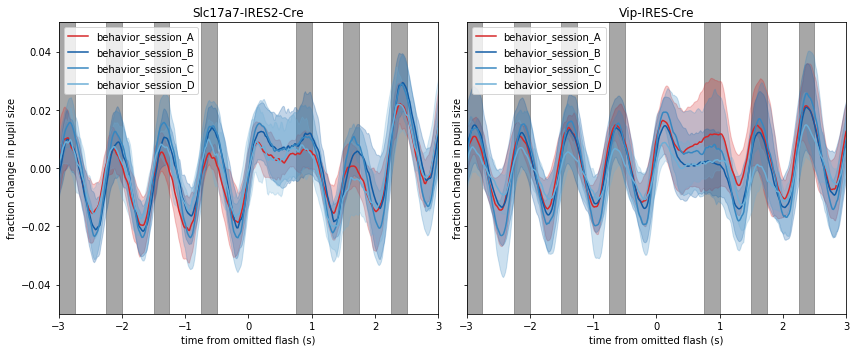

In [13]:
fig,ax=plt.subplots(1,2,figsize=(12,5),sharey=True)

for plot_col, cre_line in enumerate(good_sessions.cre_line.unique()):
    for ii,session_type in enumerate(session_types):

        # get good sessions of this session type
        sessions = good_sessions.query('session_type == @session_type and cre_line == @cre_line')

        # get the column names, excluding 'time', with a session ID matching those in the selected sessions
        cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]

        # plot standard deviation as span
        ax[plot_col].fill_between(
            omitted_response_averages['time'],
            omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
            omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
            color = colors[ii],
            alpha=0.25
        )

        # plot mean of all session averages
        ax[plot_col].plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])


        designate_flashes(ax[plot_col],omit=0,pre_color='gray',post_color='gray')
        ax[plot_col].set_xlim(-3,3)
        ax[plot_col].set_xlabel('time from omitted flash (s)')
        ax[plot_col].set_ylabel('fraction change in pupil size')
        ax[plot_col].set_ylim(-0.05,0.05)
        ax[plot_col].set_title('session_type = {}'.format(session_type))
        ax[plot_col].set_title(cre_line)

    ax[plot_col].legend(session_types,loc='upper left')
    fig.tight_layout()

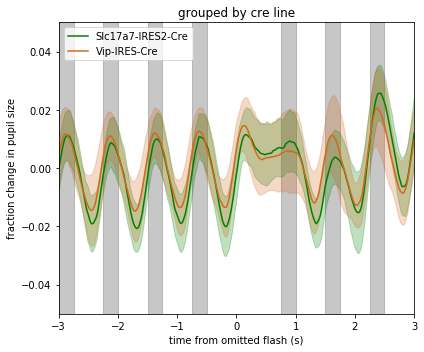

In [14]:
fig,ax=plt.subplots(1,1,figsize=(6,5),sharey=True)

cre_lines = good_sessions.cre_line.unique()
cre_colors = ['green','chocolate']
for ii,cre_line in enumerate(cre_lines):

    # get good sessions of this session type
    sessions = good_sessions.query('cre_line == @cre_line')

    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]

    # plot standard deviation as span
    ax.fill_between(
        omitted_response_averages['time'],
        omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
        omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
        color = cre_colors[ii],
        alpha=0.25
    )

    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=cre_colors[ii])


    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
    ax.set_ylim(-0.05,0.05)
    
ax.set_title('grouped by cre line')

ax.legend(cre_lines,loc='upper left')
fig.tight_layout()